# 금융분석
 * 주식 시뮬레이션 1
 * 저가에 매수 고가에 매도
 * 데일리 트레이더- 일일 매매 전략
 * 오리온(주) 테스트


In [112]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [113]:
code=271560
pgno=2
url='https://finance.naver.com/item/sise_day.nhn?code={0}&page={1}'
tgurl=url.format(code,pgno)
tgurl

'https://finance.naver.com/item/sise_day.nhn?code=271560&page=2'

In [114]:
def getDB():
    dbname='stockdata.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select * from stockp order by skey asc'
        qry=cur.execute(sql)
        desc=[row[0] for row in qry.description]
        data=qry.fetchall()
    return((desc,data))

In [115]:
res=getDB()
res[0]

['sidx', 'skey', 'sday', 'sopen', 'shigh', 'slow', 'sclose', 'svol']

In [116]:

df=pd.DataFrame(data=res[1],columns=res[0]).set_index('sidx')
df.head()

,skey,sday,sopen,shigh,slow,sclose,svol
sidx,,,,,,,
895,20170707,2017-07-07,87100,89700,75700,82300,1619864
894,20170710,2017-07-10,82300,88000,81000,88000,840451
893,20170711,2017-07-11,88000,88000,82700,82800,422303
892,20170712,2017-07-12,83700,84600,80000,83500,238407
891,20170713,2017-07-13,83400,84000,80800,81600,218138


<AxesSubplot:xlabel='sday'>

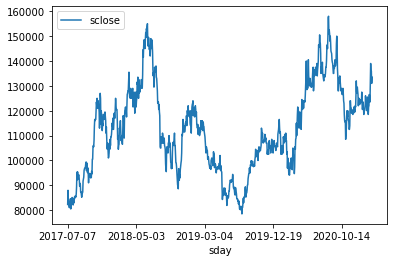

In [117]:
df.plot.line(x='sday',y='sclose')

In [118]:
cdf=df[['sday','sclose']].copy()
cdf.head()

,sday,sclose
sidx,,
895,2017-07-07,82300
894,2017-07-10,88000
893,2017-07-11,82800
892,2017-07-12,83500
891,2017-07-13,81600


In [119]:
cdf['preday']=cdf['sclose'].shift(1)
cdf=cdf.fillna(0)
cdf.head()

,sday,sclose,preday
sidx,,,
895,2017-07-07,82300,0.0
894,2017-07-10,88000,82300.0
893,2017-07-11,82800,88000.0
892,2017-07-12,83500,82800.0
891,2017-07-13,81600,83500.0


In [120]:
cdf.loc[895,'sclose']>cdf.loc[895,'preday']

True

In [121]:
cdf['updown']=(cdf['sclose']>cdf['preday']).astype(int)
cdf.head()

,sday,sclose,preday,updown
sidx,,,,
895,2017-07-07,82300,0.0,1
894,2017-07-10,88000,82300.0,1
893,2017-07-11,82800,88000.0,0
892,2017-07-12,83500,82800.0,1
891,2017-07-13,81600,83500.0,0


In [122]:
cdf['preupdown']=cdf['updown'].shift(-1)
cdf=cdf.fillna(0)
cdf.head()

,sday,sclose,preday,updown,preupdown
sidx,,,,,
895,2017-07-07,82300,0.0,1,1.0
894,2017-07-10,88000,82300.0,1,0.0
893,2017-07-11,82800,88000.0,0,1.0
892,2017-07-12,83500,82800.0,1,0.0
891,2017-07-13,81600,83500.0,0,0.0


### 투자 포인트 설정
* 즉시 매도 매수 포지션
* updown: 전일보다 상승 했는가?
* preupdown: 전일 상승 중이었는가?
* sellpos: 전일보다 상승 했으면 매수1 전일보다 하락했으면 매도-1 하락중이거나 상승중이면 홀드0

In [123]:
cdf['sellpos']= np.where(cdf['updown']<cdf['preupdown'],1,0)+np.where(cdf['updown']>cdf['preupdown'],-1,0)
cdf.head()

,sday,sclose,preday,updown,preupdown,sellpos
sidx,,,,,,
895,2017-07-07,82300,0.0,1,1.0,0
894,2017-07-10,88000,82300.0,1,0.0,-1
893,2017-07-11,82800,88000.0,0,1.0,1
892,2017-07-12,83500,82800.0,1,0.0,-1
891,2017-07-13,81600,83500.0,0,0.0,0


### 거래 가치 분석
* deb 통장잔고: 현찰
* instock 주식잔고: 주식보유수 
* cre 주식 가치:

In [124]:
def finprs(df):
    fdf=df.copy()
    precre=0 # 이전 주식 잔고
    predeb=82600 # 이전 통장 잔고
    prestock=0
    for idx,row in fdf.iterrows():
         # 살수 있는 주식의 갯수
        #사라는 신호가 왔고 주식잔고는 없다  통장에 잔고(주식을 살만한)가 있는지?
        if (row.loc['sellpos']==1 and prestock==0):
            canbuy=predeb//row.loc['sclose']
            if(canbuy>0):
                #산다
                cre=precre+canbuy*row.loc['sclose']
                deb=predeb-canbuy*row.loc['sclose']
                instock=canbuy
            else:# 돈없어서 아무일 없다
                instock=prestock
                cre=precre
                deb=predeb                
        # 팔라는 신호가 왔고 주식은 있다---> 판다
        elif (row.loc['sellpos']==-1 and prestock>0):
            cre=0
            deb=predeb+row.loc['sclose']*prestock
            instock=0
            # sellpos:1 prestock:1,sellpos:-1 prestock:0, no debt
        else:# 조건이 안맞아서 아무일 없다.
            instock=prestock
            cre=precre
            deb=predeb
        fdf.loc[idx,'hasstock']=instock
        fdf.loc[idx,'debt']=deb
        fdf.loc[idx,'credit']=cre
        prestock=instock
        precre=cre
        predeb=deb
    return fdf
rdf=finprs(cdf)
rdf.head(20)

,sday,sclose,preday,updown,preupdown,sellpos,hasstock,debt,credit
sidx,,,,,,,,,
895,2017-07-07,82300,0.0,1,1.0,0,0.0,82600.0,0.0
894,2017-07-10,88000,82300.0,1,0.0,-1,0.0,82600.0,0.0
893,2017-07-11,82800,88000.0,0,1.0,1,0.0,82600.0,0.0
892,2017-07-12,83500,82800.0,1,0.0,-1,0.0,82600.0,0.0
891,2017-07-13,81600,83500.0,0,0.0,0,0.0,82600.0,0.0
890,2017-07-14,81000,81600.0,0,1.0,1,1.0,1600.0,81000.0
889,2017-07-17,82200,81000.0,1,1.0,0,1.0,1600.0,81000.0
888,2017-07-18,83300,82200.0,1,1.0,0,1.0,1600.0,81000.0
887,2017-07-19,84600,83300.0,1,0.0,-1,0.0,86200.0,0.0


In [125]:
rdf.tail(10)

,sday,sclose,preday,updown,preupdown,sellpos,hasstock,debt,credit
sidx,,,,,,,,,
25,2021-02-08,122000,121500.0,1,1.0,0,2103.0,5400.0,249205500.0
24,2021-02-09,126500,122000.0,1,0.0,-1,0.0,266034900.0,0.0
23,2021-02-10,125000,126500.0,0,0.0,0,0.0,266034900.0,0.0
22,2021-02-15,123500,125000.0,0,1.0,1,2154.0,15900.0,266019000.0
21,2021-02-16,131500,123500.0,1,1.0,0,2154.0,15900.0,266019000.0
20,2021-02-17,139000,131500.0,1,0.0,-1,0.0,299421900.0,0.0
19,2021-02-18,135500,139000.0,0,1.0,1,2209.0,102400.0,299319500.0
18,2021-02-19,136000,135500.0,1,0.0,-1,0.0,300526400.0,0.0
17,2021-02-22,131000,136000.0,0,1.0,1,2294.0,12400.0,300514000.0


<AxesSubplot:xlabel='sday'>

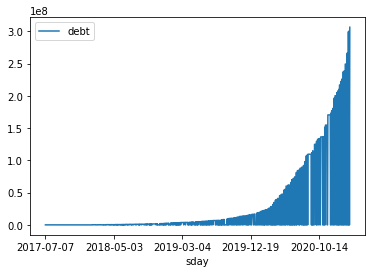

In [126]:
rdf.plot.line(x='sday',y='debt')